In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from scipy import ndimage
from PIL import Image
%matplotlib inline

In [2]:
image_size = 50 # Pixel width and height.
size = image_size,image_size
pixel_depth = 255.0 # Number of levels per pixel.
sizes = [784,622,222,473]
folders = [
    r'data2//Arms//',
    r'data2//Figure_normal_legs//',
    r'data2//FigureWheels//',
    r'data2//Head//',
]

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      img = Image.open(image_file)
      newImg = img.resize(size, Image.ANTIALIAS)
      image_data = (np.array(newImg).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset

X_datasets = list()
print(X_datasets)
Y_datasets = list()
for idx in range(len(folders)):
    folder = folders[idx] 
    X_datasets.append(load_letter(folder, sizes[idx]))
    labels = np.zeros((X_datasets[-1].shape[0],len(folders)))
    labels[:,idx] = 1
    Y_datasets.append(labels)


[]
data2//Arms//
Full dataset tensor: (784, 50, 50)
Mean: 0.112748
Standard deviation: 0.15943
data2//Figure_normal_legs//
Full dataset tensor: (622, 50, 50)
Mean: 0.0886578
Standard deviation: 0.17902
data2//FigureWheels//
Full dataset tensor: (222, 50, 50)
Mean: 0.0753042
Standard deviation: 0.184759
data2//Head//
Full dataset tensor: (473, 50, 50)
Mean: 0.0373346
Standard deviation: 0.210811


Total samples number: (2101, 50, 50)
Samples for tests: 526
Samples for trains: 1575


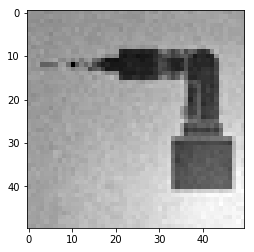

In [3]:
from sklearn.model_selection import train_test_split

X_datasets2 = np.concatenate(X_datasets)
Y_datasets2 = np.concatenate(Y_datasets)
print("Total samples number:",X_datasets2.shape)
X_trains,X_tests,Y_trains,Y_tests = train_test_split(X_datasets2,Y_datasets2,test_size=0.25)
print("Samples for tests:",Y_tests.shape[0])
print("Samples for trains:",Y_trains.shape[0])
plt.imshow(X_tests[0],cmap='gray')

In [7]:
# Create first network with Keras
from keras.models import Sequential
from keras.layers import Dense,Activation,Reshape
from keras.callbacks import EarlyStopping,ModelCheckpoint
import numpy
from keras.optimizers import SGD

callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=0.00001, verbose=1),
    # EarlyStopping(monitor='val_loss', patience=2, verbose=0),
    ModelCheckpoint(filepath='./weights.net', verbose=1, save_best_only=True),
    
]

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

input_dim = X_trains[0].shape[0]*X_trains[0].shape[1]
print((X_trains[0].shape[0],X_trains[0].shape[1]))
print(Y_trains[0].shape[0])
# create model
model = Sequential()
model.add(Reshape((input_dim,), input_shape=(X_trains[0].shape[0],X_trains[0].shape[1])))
model.add(Dense(input_dim, input_shape = (input_dim,), init='uniform', activation='relu'))
model.add(Dense(int(input_dim/2), init='uniform', activation='relu'))
model.add(Dense(Y_trains[0].shape[0],init='uniform', name="output"))
model.add(Activation('sigmoid', name="sigmoid"))
model.summary()

model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
# Fit the model
model.fit(X_trains, 
          Y_trains, 
          epochs=10, 
          batch_size=10, 
          verbose=2, 
          validation_split=0.25,
          callbacks=callbacks)
# calculate predictions
results = model.evaluate(X_tests, Y_tests, batch_size=32, verbose=1, sample_weight=None)
# round predictions
print(results)


(50, 50)
4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 2500)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 2500)              6252500   
_________________________________________________________________
dense_8 (Dense)              (None, 1250)              3126250   
_________________________________________________________________
output (Dense)               (None, 4)                 5004      
_________________________________________________________________
sigmoid (Activation)         (None, 4)                 0         
Total params: 9,383,754
Trainable params: 9,383,754
Non-trainable params: 0
_________________________________________________________________


/Users/nikita/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2500, input_shape=(2500,), activation="relu", kernel_initializer="uniform")`
/Users/nikita/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1250, activation="relu", kernel_initializer="uniform")`
/Users/nikita/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, name="output", kernel_initializer="uniform")`


Train on 1181 samples, validate on 394 samples
Epoch 1/10
Epoch 00001: val_loss improved from inf to 0.27800, saving model to ./weights.net
 - 16s - loss: 0.3302 - acc: 0.8677 - val_loss: 0.2780 - val_acc: 0.8947
Epoch 2/10
Epoch 00002: val_loss improved from 0.27800 to 0.21480, saving model to ./weights.net
 - 13s - loss: 0.1664 - acc: 0.9312 - val_loss: 0.2148 - val_acc: 0.9188
Epoch 3/10
Epoch 00003: val_loss did not improve
 - 14s - loss: 0.0963 - acc: 0.9627 - val_loss: 0.2398 - val_acc: 0.9207
Epoch 00003: early stopping
526/526 [==============================] - 0s 907us/step
[0.27845664636830414, 0.92015209148138644]
